# [E-10]프로젝트 : GAN을 활용해서 CIFAR-10 이미지 생성하기

## 프로젝트 과정

  - 데이터셋 구성 및 전처리
  - 생성자 / 판별자 모델 구현
  - 손실함수와 최적화함수 구현
  - 훈련과정 상세 기능 구현
  - 학습 진행
  - 훈련 과정 개선

### Step 1. 데이터셋 구성 및 전처리

In [1]:
# 필요한 라이브러리 구성

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
# 데이터셋 구성

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)
max pixel: 255
min pixel: 0


In [3]:
# 학습에 사용할 train_x 데이터를 -1과1로 정규화 시켜줘야 한다

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


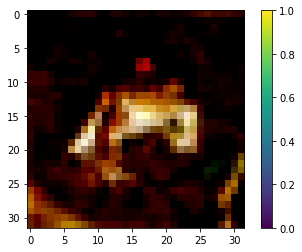

In [4]:
# 이미지 확인해보기

plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

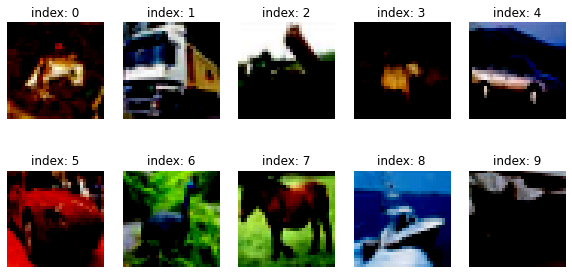

In [5]:
# 이미지 10장 뽑아서 확인해보기

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [6]:
# 미니 배치 데이터셋 준비

BUFFER_SIZE = 50000  # 전체 데이터를 섞기 위해 50000으로 설정
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Step 2. 생성자 / 판별자 모델 구현하기

In [8]:
# 생성자 모델 구현
# keras의 Sequential API를 활용함

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())  # BatchNormalization은 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화해준다.
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer는 Conv2d와 반대로 이미지 사이즈를 넓혀주는 역할을 한다.
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

print('good')

good


In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

  - 사이즈가 (8, 8, 256)에서 (16, 16, 64) 그리고 최종적으로 (32, 32, 3)으로 변하는 것을 확인할 수 있다.

In [10]:
# 랜덤 노이즈 백터를 생성해서 결과물 확인
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

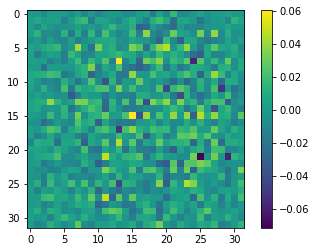

In [11]:
# Matplotlib으로 시각화하기
# Matplotlib은 2차원 이미지만 보여줄 수 있기 때문에 0번째와 3번째의 인덱스를 0으로 해서 (32,32) shape의 이미지만 출력되도록 설정해줘야 한다.

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [12]:
# 판별자 모델 구현
# 판별자 모델은 생성자 모델과 반대로 Conv2D를 통해서 이미지를 줄여나간다

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [13]:
# 가짜 이미지를 판별자 모델에 입력시켜보기

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00191794]], dtype=float32)>

### Step 3. 손실함수와 최적화함수 구현

  - GAN은 손실함수로 교차 엔트로피(cross Entropy)를 사용한다.
  - 교차 엔트로피 방식은 분류 문제를 해결할때 많이 사용된다.
  - 특히 판별자는 한개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 분류문제를 풀어야 하기 때문에 이진 교차 엔트로피 함수를 사용한다.

In [14]:
# 손실함수 구현 및 목적
# 생성자는 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것 
# 판별자는 Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
# generator_loss
# generator_loss는 fake_output이 1에 가까워지게 해야하기 때문에 tf.ones_like와의 교차 엔트로피값을 계산하면 된다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# discriminator_loss
# discriminator_loss는 fake_output은 0에 가까워지게 하고 real_output은 1에 가까워지게 해야 한다.
# 최종 discriminator_loss는 두가지의 값이 더해진 값이다.

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
# discriminator accuracy
# 판별자가 얼마나 잘 구별해 내는지에 대한 정확도도 매우 중요하다.
# 하지만 정확도가 1에 가까울수록 생성자가 만들어내는 fake_output이 real_output과 차이가 많이 나는, 즉 좋지 못한 결과물을 만들어내고 있다는 것이다.
# 가장 좋은 결과는 처음에는 1에 가깝다가 점점 0.5 수준으로 내려오는 것이 좋다.

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [18]:
# 최적화 함수로는 Adam 최적화 기법을 사용한다.
# 최적화 함수 역시 생성자와 판별자 따로 학습을 진행하기 때문에 따로 만들어줘야 한다.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
# 생성자가 생성한 샘플 확인
# 샘플은 한 번에 16장을 생성하도록 한다.

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### Step 4. 훈련 상세 과정 구현

  - 학습시킬 훈련 함수 위에 @tf.function이라는 데코레이션을 붙여서 사용한다.

In [20]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [21]:
# 일정 간격으로 학습 현황을 볼 수 있는 샘플 생성

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [22]:
# loss와 accuracy 그래프

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [23]:
# 정기적으로 모델을 저장하기 위한 checkpoint 만들기

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Step 5. 모델 학습 진행

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [65]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

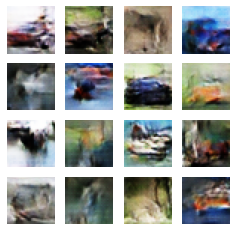

Time for training : 4767 sec


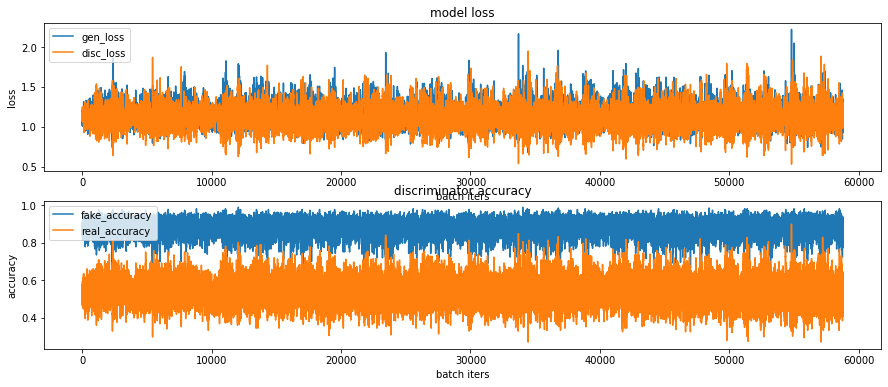

CPU times: user 1h 21min 39s, sys: 7min 57s, total: 1h 29min 37s
Wall time: 1h 19min 31s


In [66]:
%%time
train(train_dataset, EPOCHS, save_every)

In [67]:
# 학습 과정 시각화하기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2247606 Feb  8 11:21 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


### 추가적으로 500 EPOCHS 추가해서 학습하기

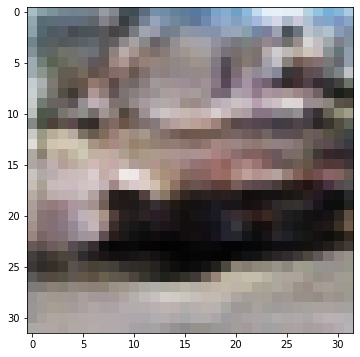

In [24]:
# checkpoint 모듈 활용해서 다시 재학습

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [28]:
save_every = 5
EPOCHS = 500

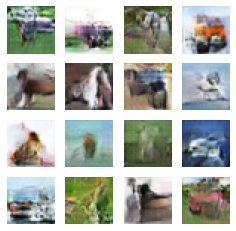

Time for training : 8480 sec


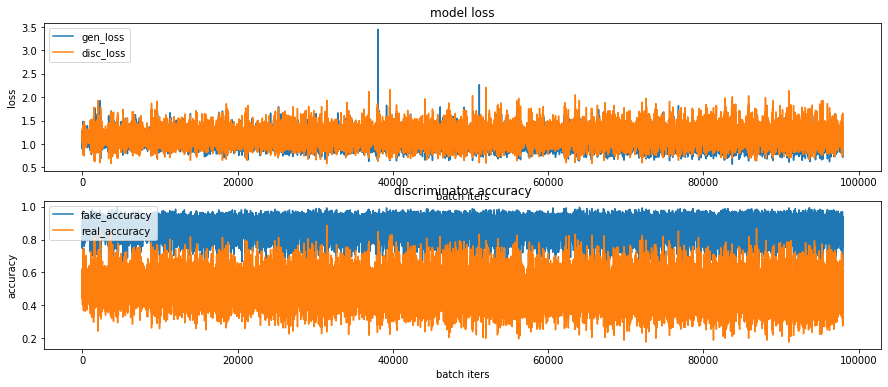

CPU times: user 2h 25min 2s, sys: 13min 18s, total: 2h 38min 21s
Wall time: 2h 21min 26s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

In [30]:
# 학습 과정 시각화하기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2747261 Feb  9 05:06 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


### 100 EPOCHS 추가해서 학습하기

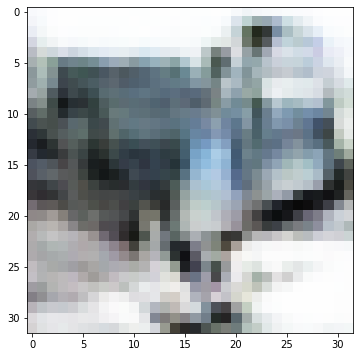

In [31]:
# checkpoint 모듈 활용해서 다시 재학습

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [32]:
save_every = 5
EPOCHS = 100

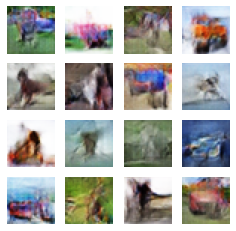

Time for training : 1522 sec


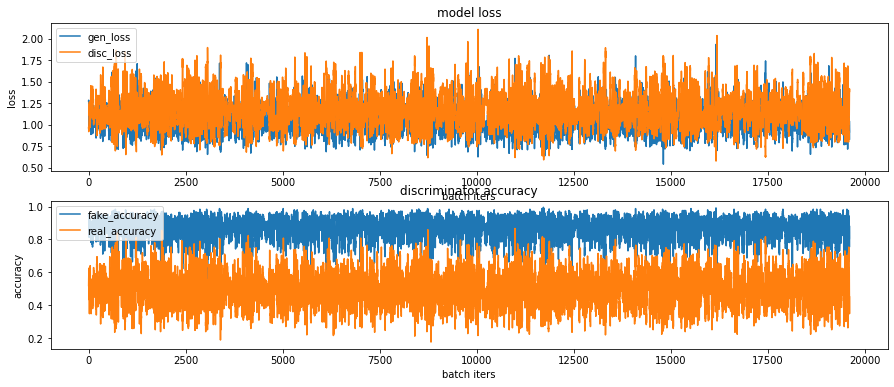

CPU times: user 26min 11s, sys: 2min 36s, total: 28min 48s
Wall time: 25min 23s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

In [34]:
# 학습 과정 시각화하기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_100epochs.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_100epochs.gif

-rw-r--r-- 1 root root 2767711 Feb  9 05:40 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_100epochs.gif


### learning rate 변경해서 50 EPOCHS 재학습

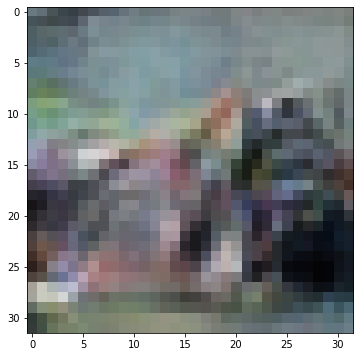

In [35]:
# checkpoint 모듈 활용해서 다시 재학습

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)
save_every = 5
EPOCHS = 50

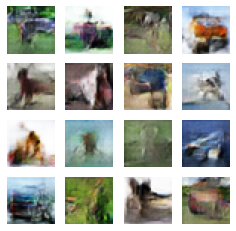

Time for training : 768 sec


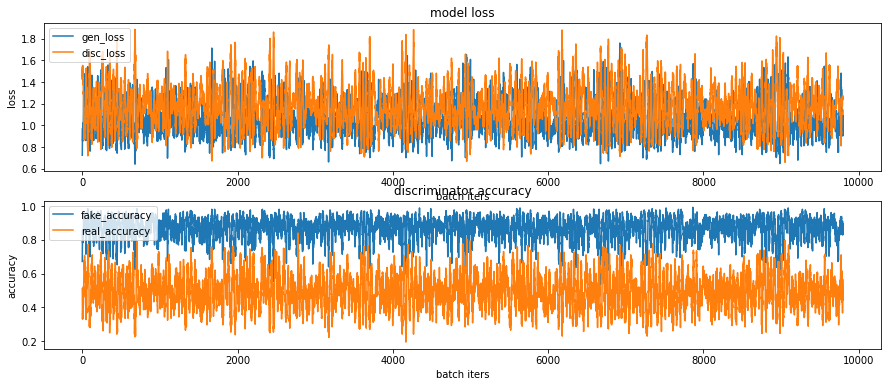

CPU times: user 13min 7s, sys: 1min 17s, total: 14min 24s
Wall time: 12min 50s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every)

In [38]:
# 학습 과정 시각화하기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_learning_rate.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_learning_rate.gif

-rw-r--r-- 1 root root 2766359 Feb  9 06:02 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_learning_rate.gif


## 회고

### 1. 첫 300epochs로 모델 훈련

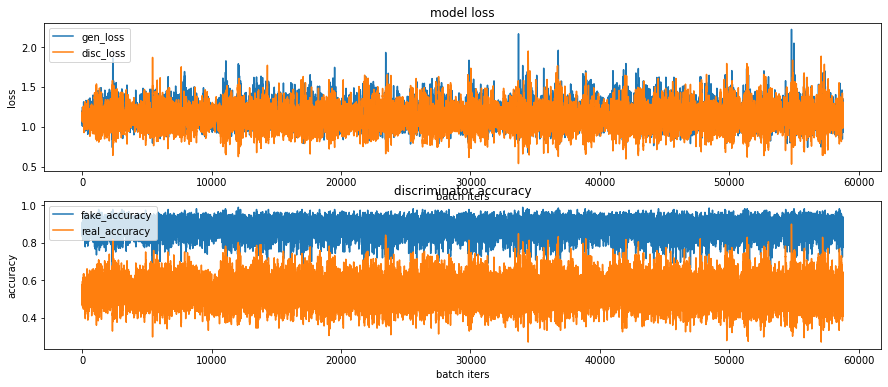
  - 그래프를 보면 알 수 있듯이 fake, real accuracy가 목표했던 0.5에 수렴하도록 하는데는 아직 많이 부족한 것 같다.
  - 아직은 모델이 이미지를 높은 수준의 이미지로 생성하지 못하는 것 같다.

### 2. 500epochs를 추가해서 모델 훈련

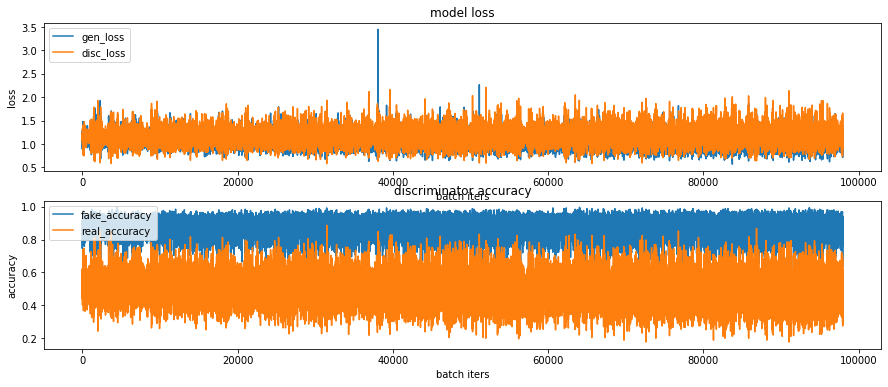

  - 아까 첫 300epochs만으로 모델을 훈련했을 때보다는 좀 더 변화가 나타난 것 같다.
  - 하지만 아직도 fake_acuuracy는 0.5 수준까지는 미치지 못하는 것 같다.

### 3. 100epochs를 추가해서 모델 훈련

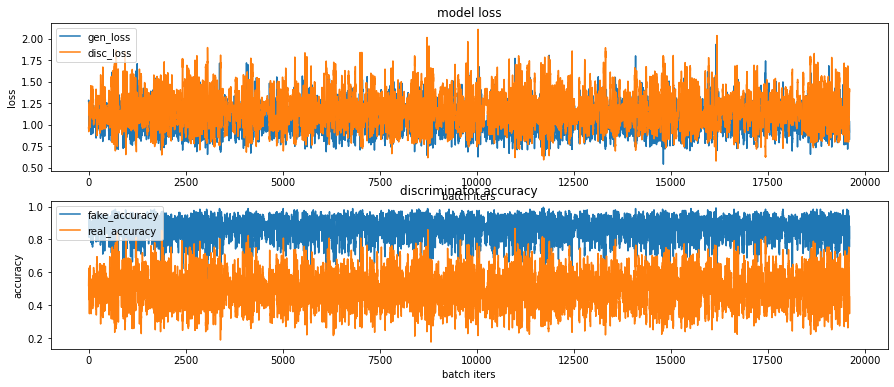

  - 0.5 수준의 이미지들도 보이는 것 같다.
  - epochs를 많이 돌릴수록 모델의 성능이 향상될줄 알았는데 눈에 띄게 성능이 향상되는 것 같지는 않다.
  - 다른 모델 개선 방법을 찾아서 시도해봐야 할 것 같다.

### 4. learning_rate 변경 및 50epochs 추가해서 모델 훈련

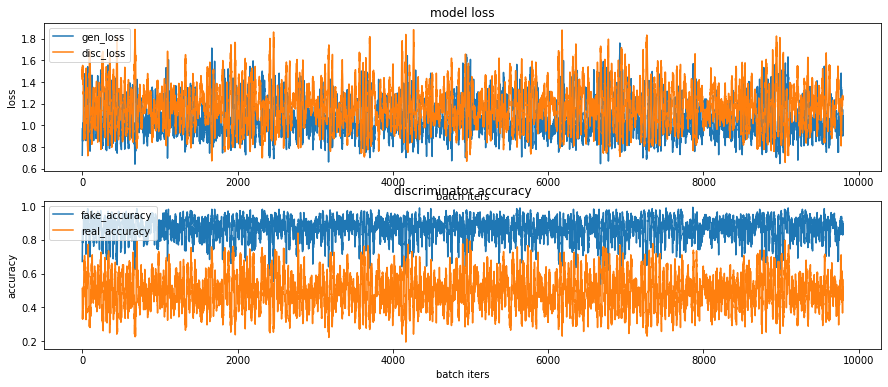

  - 이번에는 learning_rate를 변경해서 모델을 훈련시켜보았다.
  - 다른 모델 개선 방법들도 있는거 같지만 일단 내가 건들만큼 아는 부분은 learning_rate가 가장 좋을 것 같아서 수치에 변화를 주었다.
  - 모델의 성능이 확 좋아졌다고 말할 수는 없지만 그래도 이전 epochs만 늘려서 훈련하던것 보다는 좀 더 괜찮은 이미지를 생성해내는 것 같다.

  - 처음 300epochs 훈련 후 500epochs 추가 훈련
https://8888-wr04olct82dsftqx3abchlu8t.e.prod.connect.ainize.ai/view/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif
  - 두번째 100epochs 추가 후 훈련
https://8888-wr04olct82dsftqx3abchlu8t.e.prod.connect.ainize.ai/view/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_100epochs.gif
  - 세번째 learning_rate 추가 후 훈련
https://8888-wr04olct82dsftqx3abchlu8t.e.prod.connect.ainize.ai/view/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_learning_rate.gif

### 개인적인 느낀점

  - 이번 노드는 시간이 오래 걸린다고 미리 들어서 진행할때 있어서 조금 걱정을 하였지만 생각만큼 오래걸리지는 않았던 것 같다.
  - 특히 이번 노드에서는 모델을 훈련시키고 그에 따른 결과들을 보고 또 조금씩 수정해가면서 결과를 얻을 수 있다는 점이 재미있었던 것 같다.
  - 하지만 모델 개선 부분에서 노드에서 제시해주는 문서들이 영어로 작성된게 많아서 내가 바로 이해했는지 확신할 수 없었고 또 그 방법을 시도하기도 좀 어려웠던 것 같다.
  - 구글이나 깃허브에도 또 다른 방법들이 있는지 검색해보았지만 역시 많은 자료들이 영어로 되어 있어서 영어 공부도 해야한다는 생각이 들었다.